In [ ]:
#connect to google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/comp4211_project_data"

/content/drive/My Drive/comp4211_project_data


In [ ]:
#libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn import decomposition
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import random
from lightgbm import LGBMClassifier

In [ ]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(cm):

  tn, fp, fn, tp = cm.ravel()
  print("True Positive:" + str(tp))
  print("True Negative:" + str(tn))
  print("False Positve:" + str(fp))
  print("False Negative:" + str(fn))

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')


  plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

def over_sampling(x,y,over_ratio=0.5):
  rt_x, rt_y = RandomOverSampler(random_state=0,sampling_strategy=over_ratio).fit_resample(x,y)
  rt_x, rt_y = RandomUnderSampler(random_state=0,sampling_strategy="majority").fit_resample(rt_x,rt_y)

  return rt_x, rt_y
def smote_sampling(x,y,over_ratio=0.5):
  rt_x, rt_y = SMOTE(random_state=0,sampling_strategy=over_ratio).fit_resample(x,y)
  rt_x, rt_y = RandomUnderSampler(random_state=0,sampling_strategy="majority").fit_resample(rt_x,rt_y)

  return rt_x, rt_y

def under_sampling(x,y):
  rt_x, rt_y = RandomUnderSampler(random_state=0,sampling_strategy="majority").fit_resample(x,y)

  return rt_x, rt_y

In [ ]:
from sklearn.metrics import classification_report

def prediction_analyze(test_y,predict_y):
  accuracy = accuracy_score(test_y, predict_y)
  F1 = f1_score(test_y, predict_y, average="binary")
  print("accuracy: " + str(accuracy))
  print("F1: " + str(F1))

  print(classification_report(test_y,predict_y))

In [ ]:
#load dataset
#The method I used in clean the data is totallly the same as the author except that I drop duplicated data at last.
credit_data = pd.read_csv("credit_record.csv")
app_data = pd.read_csv("application_record.csv")
print(credit_data.shape)
print(app_data.shape)
app_data['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)
app_data.drop('FLAG_MOBIL', axis=1, inplace=True)

credit_data['target']=credit_data['STATUS']
credit_data['target'].replace('X', 0, inplace=True)
credit_data['target'].replace('C', 0, inplace=True)
credit_data['target']=credit_data['target'].astype(int)
credit_data.loc[credit_data['target']>=1,'target']=1

target_data = pd.DataFrame(credit_data.groupby(['ID'])['target'].agg(max)).reset_index()
dataset = pd.merge(app_data, target_data, how='inner', on=['ID'])

mbalance_data = pd.DataFrame(credit_data.groupby(['ID'])['MONTHS_BALANCE'].agg(min)).reset_index()
mbalance_data.rename(columns={'MONTHS_BALANCE':'ACCOUNT_LENGTH'}, inplace=True)
mbalance_data['ACCOUNT_LENGTH']=-mbalance_data['ACCOUNT_LENGTH']
dataset = pd.merge(dataset, mbalance_data, how='inner', on=['ID'])

dataset['AGE_YEARS']=-dataset['DAYS_BIRTH']/365.2425
dataset.drop('DAYS_BIRTH', axis=1, inplace=True)

dataset['UNEMPLOYED']=0
dataset.loc[-dataset['DAYS_EMPLOYED']<0,'UNEMPLOYED']=1

dataset['YEARS_EMPLOYED']=-dataset['DAYS_EMPLOYED']/365.2425
dataset.loc[dataset['YEARS_EMPLOYED']<0,'YEARS_EMPLOYED']=0
dataset.drop('DAYS_EMPLOYED', axis=1, inplace=True)

dataset["CODE_GENDER"] = dataset["CODE_GENDER"].replace(['F','M'],[0,1])
dataset["FLAG_OWN_CAR"] = dataset["FLAG_OWN_CAR"].replace(["Y","N"],[1,0])
dataset["FLAG_OWN_REALTY"] = dataset["FLAG_OWN_REALTY"].replace(["Y","N"],[1,0])

dataset = dataset.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Own_car', 
                'FLAG_OWN_REALTY':'Own_property','CNT_CHILDREN':'Num_children',
                'AMT_INCOME_TOTAL':'Total_income','NAME_INCOME_TYPE':'Income_type',
                'NAME_EDUCATION_TYPE':'Education_type','NAME_FAMILY_STATUS':'Family_status',
                'NAME_HOUSING_TYPE':'Housing_type','FLAG_WORK_PHONE':'Work_phone',
                'FLAG_PHONE':'Phone','FLAG_EMAIL':'Email','OCCUPATION_TYPE':'Occupation_type',
                'CNT_FAM_MEMBERS':'Num_family','target':'Target','ACCOUNT_LENGTH':'Account_length',
                'AGE_YEARS':'Age','UNEMPLOYED':'Unemployed','YEARS_EMPLOYED':'Years_employed'})
dataset['Num_family']=dataset['Num_family'].astype(int)

dataset=dataset[['ID', 'Gender', 'Own_car', 'Own_property', 'Work_phone',
        'Phone', 'Email', 'Unemployed', 'Num_children', 'Num_family', 
        'Account_length', 'Total_income', 'Age', 'Years_employed',  
        'Income_type', 'Education_type', 'Family_status',
        'Housing_type', 'Occupation_type','Target']]

dataset=dataset.drop_duplicates(subset=dataset.columns[1:], keep='first')

print(dataset.shape)
dataset.nunique()

(1048575, 3)
(438557, 18)
(32595, 20)


ID                 32595
Gender                 2
Own_car                2
Own_property           2
Work_phone             2
Phone                  2
Email                  2
Unemployed             2
Num_children           9
Num_family            10
Account_length        61
Total_income         265
Age                 7183
Years_employed      3640
Income_type            5
Education_type         5
Family_status          5
Housing_type           6
Occupation_type       19
Target                 2
dtype: int64

In [ ]:
#check whether the data contain missing values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32595 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               32595 non-null  int64  
 1   Gender           32595 non-null  int64  
 2   Own_car          32595 non-null  int64  
 3   Own_property     32595 non-null  int64  
 4   Work_phone       32595 non-null  int64  
 5   Phone            32595 non-null  int64  
 6   Email            32595 non-null  int64  
 7   Unemployed       32595 non-null  int64  
 8   Num_children     32595 non-null  int64  
 9   Num_family       32595 non-null  int64  
 10  Account_length   32595 non-null  int64  
 11  Total_income     32595 non-null  float64
 12  Age              32595 non-null  float64
 13  Years_employed   32595 non-null  float64
 14  Income_type      32595 non-null  object 
 15  Education_type   32595 non-null  object 
 16  Family_status    32595 non-null  object 
 17  Housing_type

In [ ]:
#drop duplicate
dataset.drop_duplicates(inplace=True)
print(dataset.shape)

(32595, 20)


High Risk and Low Risk Percentage:
0    0.874797
1    0.125203
Name: Target, dtype: float64


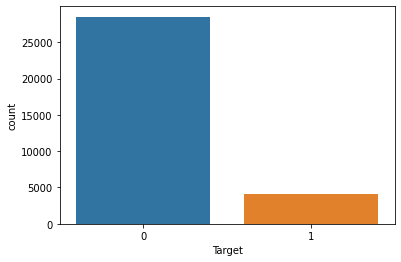

In [ ]:
#Explore the data - Target
percentage = dataset["Target"].value_counts()/len(dataset)
print("High Risk and Low Risk Percentage:")
print(percentage)
sns.countplot(x=dataset["Target"])

In [ ]:
#Prepare a dataset for visualization
dataset_visual = dataset.copy()
continuous_cols = ["Num_children","Num_family","Account_length","Total_income","Age","Years_employed"]

for name in continuous_cols:
  
  M = dataset_visual[name].max()
  m = dataset_visual[name].min()
  section = (M-m)*1.0/10 #divide in 10 groups

  for i in range(10):
    dataset_visual[name][(dataset_visual[name]>=m+i*section) & (dataset_visual[name]<=m+(i+1)*section)] = int(m+(i+1)*section-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


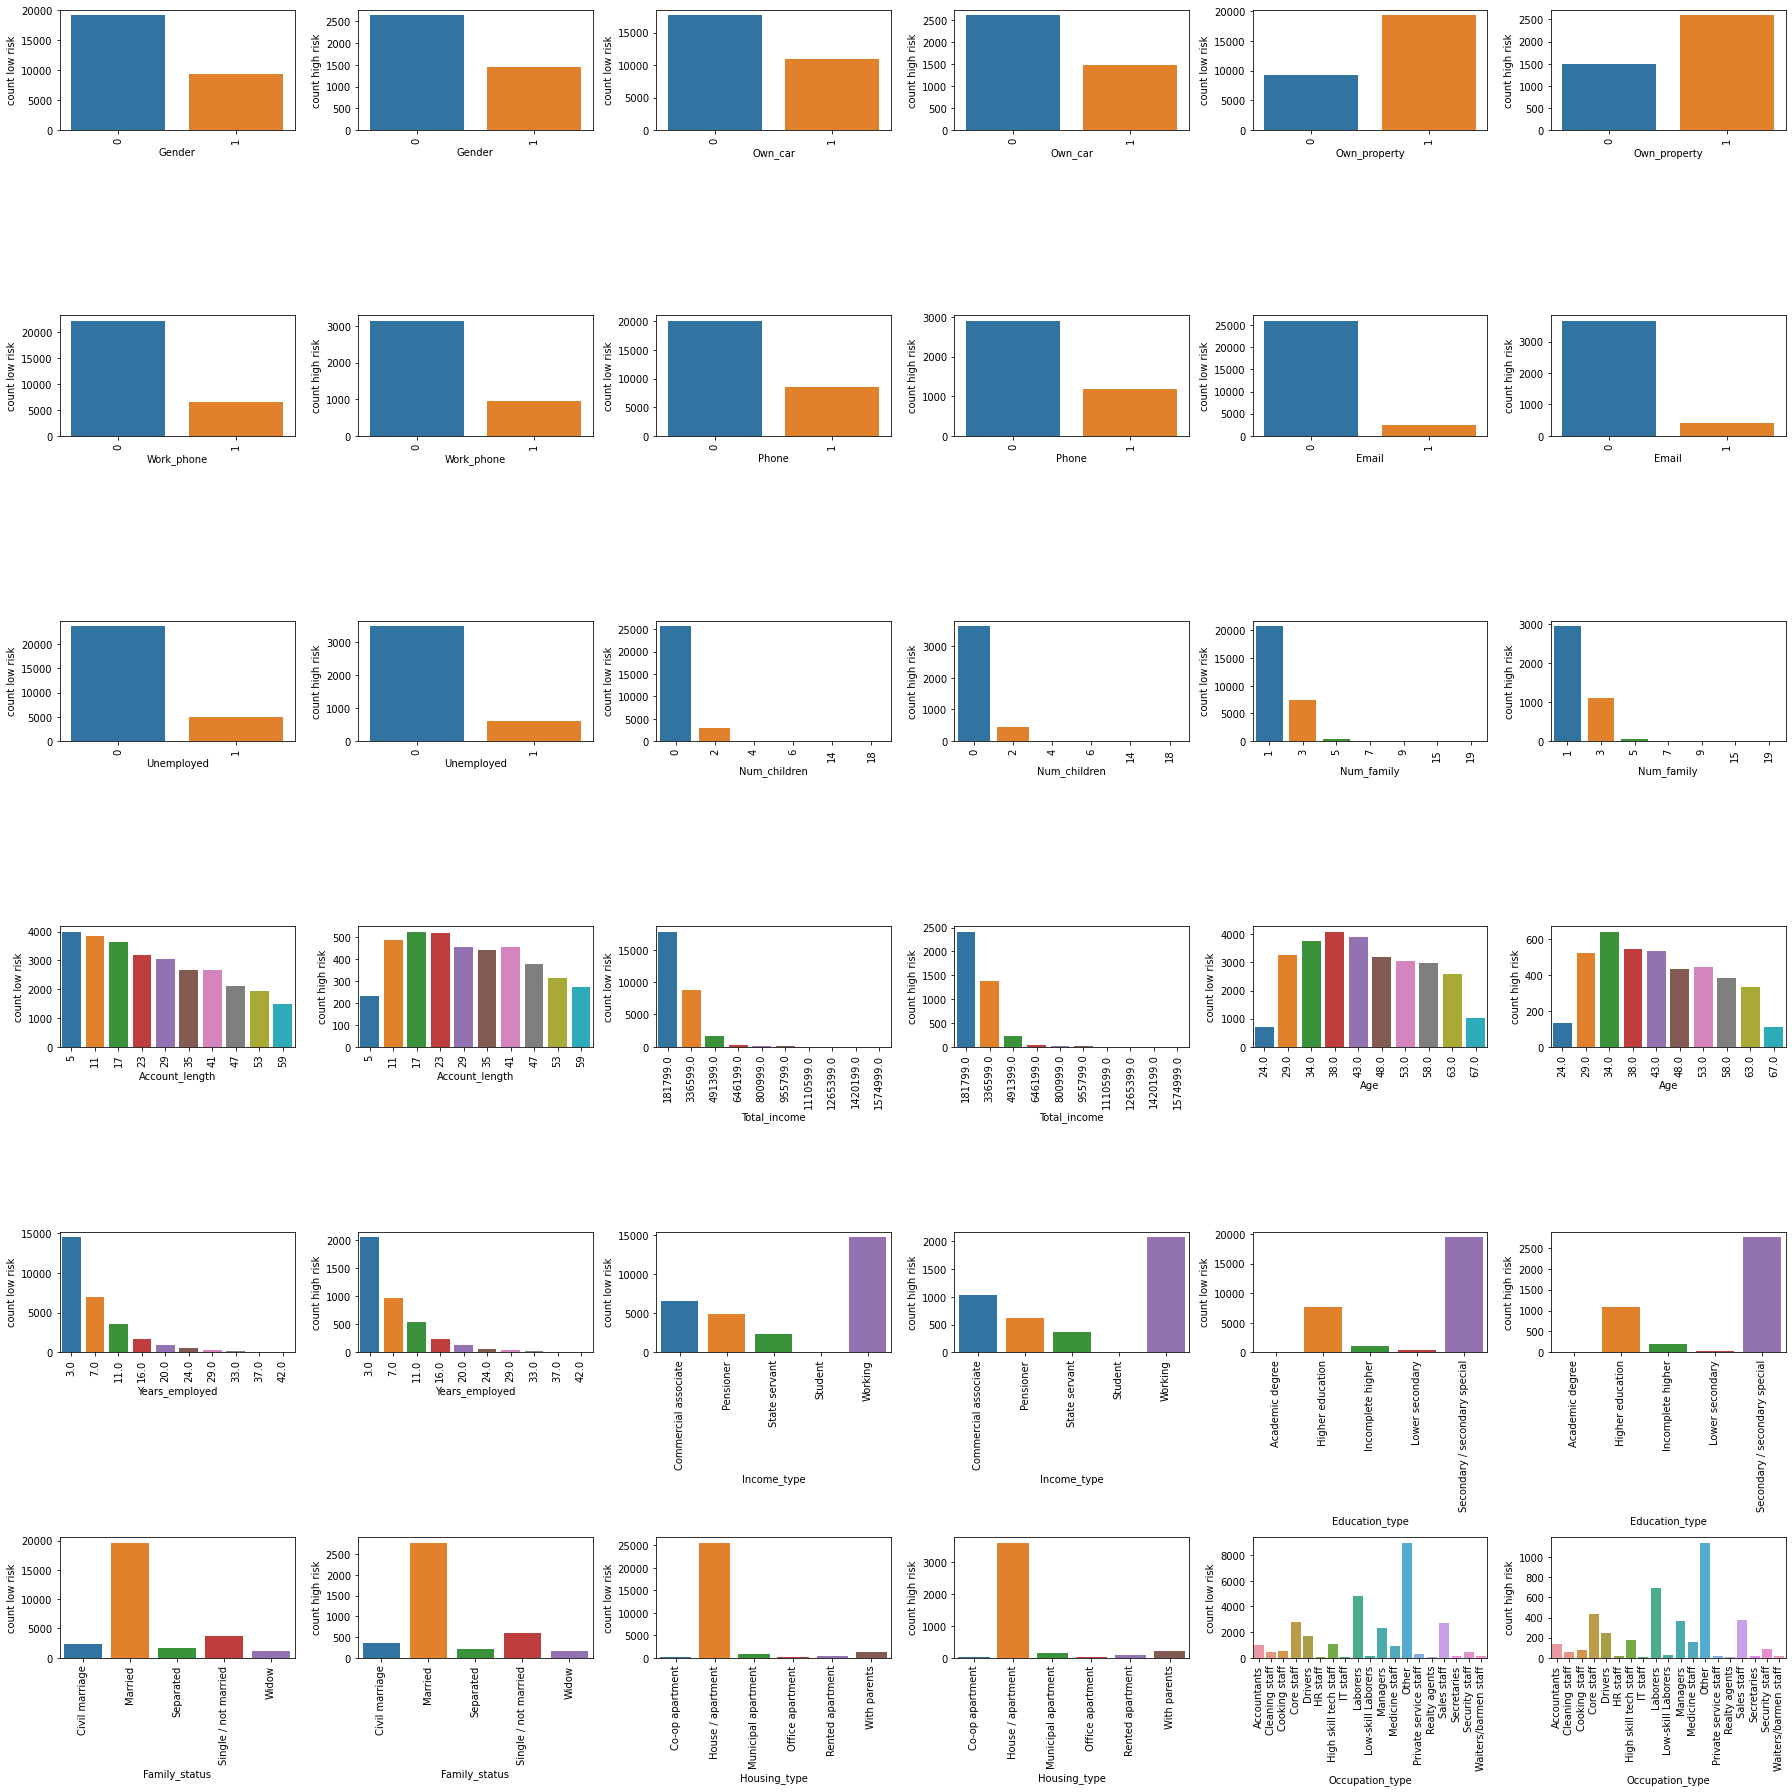

In [ ]:
#Explore the relationship between each column and Target
excludes = ["ID","Target"]
plt_idx = 1

plt.figure(figsize=(25,25))
for name in dataset_visual.columns:

  if(name in excludes):
    continue

  plt.subplot(6,6,2*plt_idx-1)
  sns.countplot(x=dataset_visual[dataset_visual["Target"]==0][name],order=dataset_visual[name].value_counts().sort_index().index)
  plt.xticks(rotation='vertical')
  plt.ylabel("count low risk")
  plt.tight_layout()
  plt.subplot(6,6,2*plt_idx)
  sns.countplot(x=dataset_visual[dataset_visual["Target"]==1][name],order=dataset_visual[name].value_counts().sort_index().index)
  plt.xticks(rotation='vertical')
  plt.ylabel("count high risk")
  plt.tight_layout()
  
  plt_idx += 1

In [ ]:
#one hot encoding for categorical data
categorical_cols = []
for col in dataset:
  if(dataset[col].dtype == np.object_):
    categorical_cols.append(col)
dataset_one_hot = pd.get_dummies(data=dataset, columns=categorical_cols, drop_first=True)

#Label encoder
# from sklearn.preprocessing import LabelEncoder
# label_enc = LabelEncoder()
# for col in dataset:
#   if(dataset[col].dtype == np.object_):
#     dataset[col] = label_enc.fit_transform(dataset[col])
print(dataset_one_hot.shape)
dataset_one_hot.head()

(32595, 50)


,ID,Gender,Own_car,Own_property,Work_phone,Phone,Email,Unemployed,Num_children,Num_family,...,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Other,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Waiters/barmen staff
0,5008804,1,1,1,1,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
1,5008805,1,1,1,1,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0
2,5008806,1,1,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,0
3,5008808,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,5008809,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
dataset_one_hot = dataset_one_hot.drop(["ID"], axis=1) #ignore ID column
dataset_one_hot.drop_duplicates(inplace=True)

dataset_x = dataset_one_hot.drop(["Target"],axis=1).to_numpy()
dataset_y = dataset_one_hot["Target"].to_numpy()

print(dataset_x.shape)

(32595, 48)


In [ ]:
#split dataset in training set and testing set
train_x,test_x,train_y,test_y = train_test_split(dataset_x,dataset_y, test_size=0.2, random_state=0, stratify=dataset_y, shuffle=True)

print(train_x.shape,train_y.shape)
print(test_x.shape,test_y.shape)

(26076, 48) (26076,)
(6519, 48) (6519,)


In [ ]:
#scaling
print("Before scaling:")
print(train_x[0])

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
#validate_x = scaler.transform(validate_x)
test_x = scaler.transform(test_x)

print("After scaling:")
print(train_x[0])

Before scaling:
[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 4.40000000e+01 1.12500000e+05 3.09246596e+01
 1.21590450e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
After scaling:
[ 1.42477334 -0.78218829 -1.43259329 -0.53626163 -0.64475735 -0.31684768
 -0.45189788 -0.58350637 -1.31510129  1.08516307 -0.7326468  -1.11082094
  0.94459212 -0.45288203 -0.29710004 -0.01638652  0.97111794 -0.60416984
 -0.19719144 -0.1

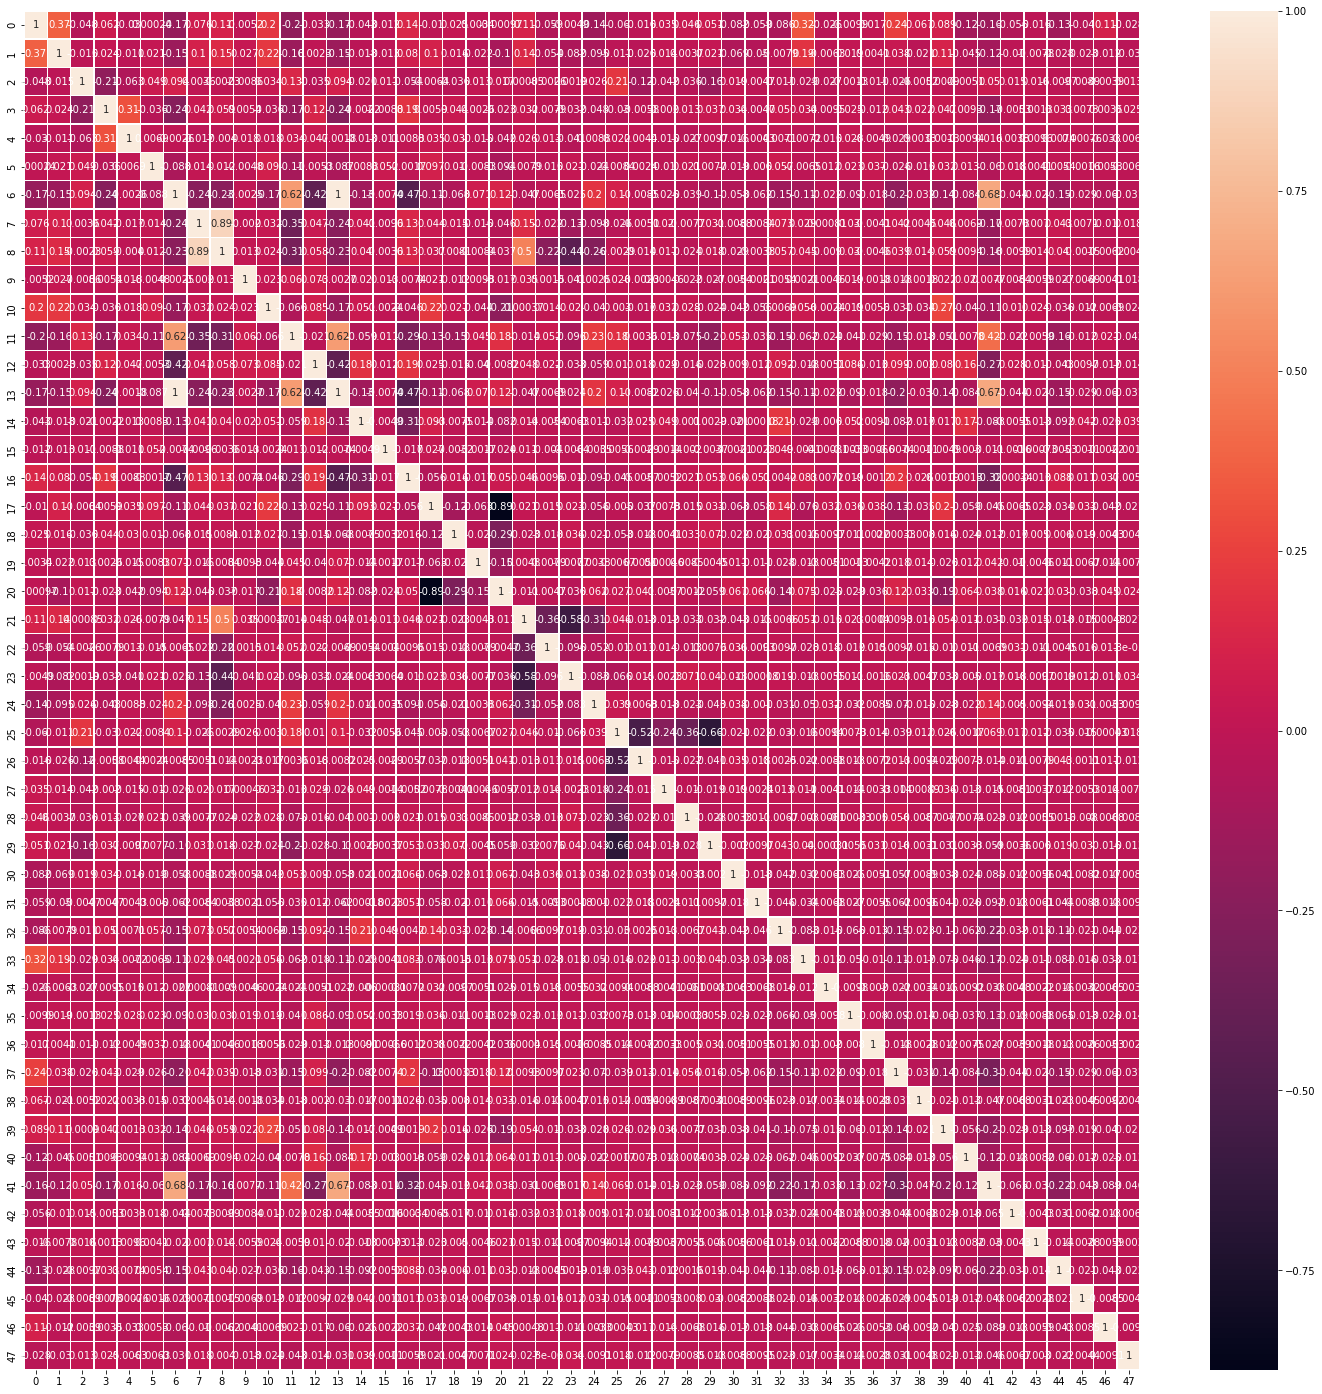

In [ ]:
#heatmap
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(pd.DataFrame(train_x).corr(), annot=True,linewidth=0.5,ax=ax)

score: 0.519448698315467


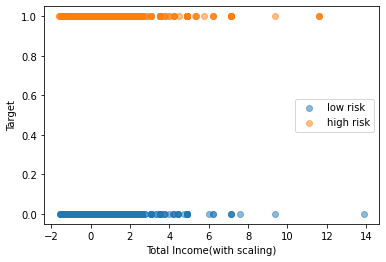

In [ ]:
#Try linear classifier for income vs risk (not linear seperable)
dataset_pd_x = dataset_one_hot.drop(["Target"],axis=1)

resample_x, resample_y = under_sampling(train_x[:,dataset_pd_x.columns.get_loc("Total_income")].reshape(-1,1),train_y)
model = SGDClassifier(loss="log", penalty="l2", eta0=0.01, learning_rate="adaptive",random_state=0).fit(resample_x,resample_y)

print("score:", str(model.score(resample_x.reshape(-1,1),resample_y)))
plt.scatter(resample_x[resample_y==0],resample_y[resample_y==0],label="low risk",alpha=0.5)
plt.scatter(resample_x[resample_y==1],resample_y[resample_y==1],label="high risk",alpha=0.5)

plt.xlabel("Total Income(with scaling)")
plt.ylabel("Target")
plt.legend()

In [ ]:
#Try linear classifier for account length vs risk (not linear seperable)
for name in dataset_pd_x.columns:

  resample_x, resample_y = under_sampling(train_x[:,dataset_pd_x.columns.get_loc(name)].reshape(-1,1),train_y) #same number of high risk and low risk
  model = SGDClassifier(loss="log", penalty="l2", eta0=0.01, learning_rate="adaptive",random_state=0).fit(resample_x,resample_y)
  score = model.score(resample_x.reshape(-1,1),resample_y)
  if(score > 0.52):
    print("score with " + name + ": " + str(score))


score with Own_property: 0.5234303215926494
score with Account_length: 0.5396630934150076


Text(0, 0.5, 'cumulative explained variance')

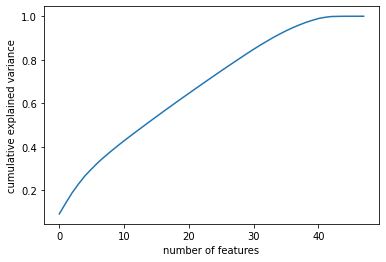

In [ ]:
#PCA graph
pca = decomposition.PCA().fit(train_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance')

In [ ]:
#PCA with proportion of variance (PoV) >= 90%
pca = decomposition.PCA(n_components=0.9).fit(train_x)
train_pca_x = pca.transform(train_x)
# validate_pca_x = pca.transform(validate_x)
test_pca_x = pca.transform(test_x)

print("number of features remain using PCA: " + str(train_pca_x.shape[1]))

number of features remain using PCA: 34


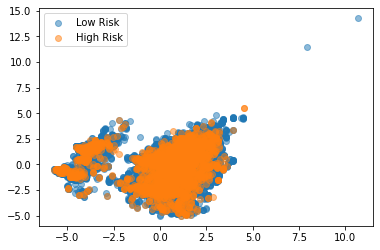

In [ ]:
#Use PCA to visualize the dataset in 2D
pca = decomposition.PCA(n_components=2).fit(train_x)
x_visual = pca.transform(train_x)

plt.clf()
plt.scatter(x_visual[train_y==0,0],x_visual[train_y==0,1],label="Low Risk",alpha=0.5)
plt.scatter(x_visual[train_y==1,0],x_visual[train_y==1,1],label="High Risk",alpha=0.5)
plt.legend()

<Figure size 432x288 with 0 Axes>

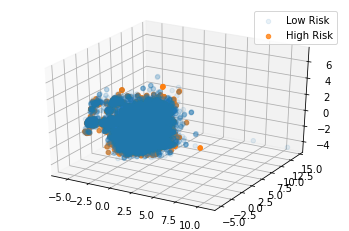

In [ ]:
#Use PCA to visualize the dataset in 3D
pca = decomposition.PCA(n_components=3).fit(train_x)
x_visual = pca.transform(train_x)

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_visual[train_y==0,0],x_visual[train_y==0,1],x_visual[train_y==0,2],label="Low Risk",alpha=0.1)
ax.scatter(x_visual[train_y==1,0],x_visual[train_y==1,1],x_visual[train_y==1,2],label="High Risk",alpha=0.8)
plt.legend()

In [ ]:
#RandomForestClassifier without tuning class weight or resampling
model = RandomForestClassifier(n_estimators=300,max_features="sqrt",max_depth=50,min_samples_leaf=50,bootstrap=True,random_state=0)
model.fit(train_x, train_y)
predict_y = model.predict(test_x)

accuracy: 0.8748274275195582
F1: 0.0
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      5703
           1       0.00      0.00      0.00       816

    accuracy                           0.87      6519
   macro avg       0.44      0.50      0.47      6519
weighted avg       0.77      0.87      0.82      6519

True Positive:0
True Negative:5703
False Positve:0
False Negative:816


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


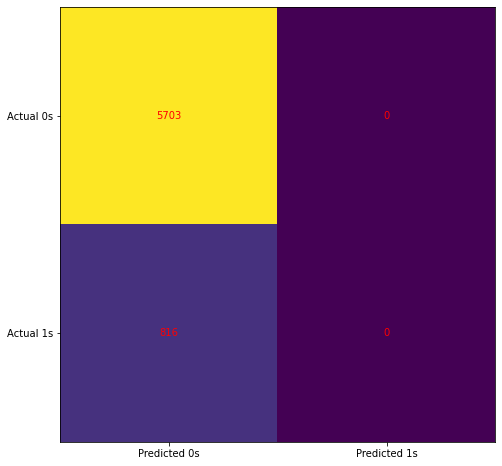

In [ ]:
#Show result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

In [ ]:
#Grid Search on best params for RandomForestClassifier with class weight
#hide it to prevent accidently run it
# n_estimators = [int(x) for x in np.linspace(start=100,stop=500,num=50)]
# max_features = ['auto','sqrt']
# max_depth = [int(x) for x in np.linspace(10,100,num=10)]
# min_samples_leaf = [int(x) for x in np.linspace(start=5,stop=25,num=5)]
# bootstrap = [True, False]
# class_weight = [{0:1,1:5},{0:1,1:10},{0:1,1:15},{0:1,1:20},{0:1,1:25},{0:1,1:30},{0:1,1:35},{0:1,1:40}]
# random_grid = {'n_estimators': n_estimators,
#          'max_features': max_features,
#          'max_depth': max_depth,
#          'min_samples_leaf': min_samples_leaf,
#          'bootstrap': bootstrap,
#          'class_weight': class_weight}

# model = RandomForestClassifier(random_state=0)
# cv = KFold(3, shuffle=True, random_state=4211)
# rs = RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=100,cv=cv,verbose=3,scoring="f1",random_state=0)
# rs.fit(train_x,train_y)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 30}, max_depth=70, max_features=sqrt, min_samples_leaf=5, n_estimators=246;, score=0.251 total time=   3.0s
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 30}, max_depth=70, max_features=sqrt, min_samples_leaf=5, n_estimators=246;, score=0.229 total time=   2.3s
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 30}, max_depth=70, max_features=sqrt, min_samples_leaf=5, n_estimators=246;, score=0.244 total time=   2.3s
[CV 1/3] END bootstrap=False, class_weight={0: 1, 1: 5}, max_depth=80, max_features=auto, min_samples_leaf=10, n_estimators=238;, score=0.084 total time=   1.8s
[CV 2/3] END bootstrap=False, class_weight={0: 1, 1: 5}, max_depth=80, max_features=auto, min_samples_leaf=10, n_estimators=238;, score=0.113 total time=   1.9s
[CV 3/3] END bootstrap=False, class_weight={0: 1, 1: 5}, max_depth=80, max_features=auto, min_samples_leaf=10, n_estimators=238;, sc

{'n_estimators': 271,
 'min_samples_leaf': 20,
 'max_features': 'sqrt',
 'max_depth': 40,
 'class_weight': {0: 1, 1: 10},
 'bootstrap': True}

In [ ]:
#build RandomForestClassifier with best params
model = RandomForestClassifier(n_estimators=271,max_features="sqrt",max_depth=40,min_samples_leaf=20,bootstrap=True,class_weight={0:1,1:7},random_state=0)
model.fit(train_x, train_y)
predict_y = model.predict(test_x)

accuracy: 0.794600398834177
F1: 0.34201474201474197
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      5703
           1       0.29      0.43      0.34       816

    accuracy                           0.79      6519
   macro avg       0.60      0.64      0.61      6519
weighted avg       0.83      0.79      0.81      6519

True Positive:348
True Negative:4832
False Positve:871
False Negative:468


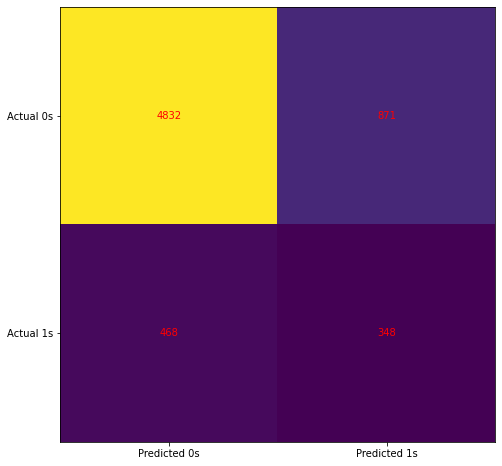

In [ ]:
#Result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

In [ ]:
#Grid Search on best params for RandomForestClassifier with training set after random over-sampling
#hide it to prevent accidently run it

# n_estimators = [int(x) for x in np.linspace(start=100,stop=500,num=50)]
# max_features = ['auto','sqrt']
# max_depth = [int(x) for x in np.linspace(10,100,num=10)]
# min_samples_leaf = [int(x) for x in np.linspace(start=5,stop=25,num=5)]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#          'max_features': max_features,
#          'max_depth': max_depth,
#          'min_samples_leaf': min_samples_leaf,
#          'bootstrap': bootstrap}

# resample_x, resample_y = over_sampling(train_x,train_y,0.5)
# model = RandomForestClassifier(random_state=0)
# cv = KFold(3, shuffle=True, random_state=4211)
# rs = RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=100,cv=cv,verbose=3,scoring="f1",random_state=0)
# rs.fit(resample_x,resample_y)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=25, n_estimators=361;, score=0.704 total time=   7.1s
[CV 2/3] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=25, n_estimators=361;, score=0.694 total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=25, n_estimators=361;, score=0.702 total time=   4.9s
[CV 1/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, n_estimators=467;, score=0.799 total time=  10.1s
[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, n_estimators=467;, score=0.801 total time=   9.8s
[CV 3/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, n_estimators=467;, score=0.802 total time=  10.3s
[CV 1/3] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=5, n_estimators=214;, score=0.813 total time=   3.8s
[

{'n_estimators': 483,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [ ]:
#Grid Search on best params for RandomForestClassifier with training set after SMOTE sampling
#hide it to prevent accidently run it

# n_estimators = [int(x) for x in np.linspace(start=100,stop=500,num=50)]
# max_features = ['auto','sqrt']
# max_depth = [int(x) for x in np.linspace(10,100,num=10)]
# min_samples_leaf = [int(x) for x in np.linspace(start=5,stop=25,num=5)]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#          'max_features': max_features,
#          'max_depth': max_depth,
#          'min_samples_leaf': min_samples_leaf,
#          'bootstrap': bootstrap}

# resample_x, resample_y = smote_sampling(train_x,train_y,0.5)
# model = RandomForestClassifier(random_state=0)
# cv = KFold(3, shuffle=True, random_state=4211)
# rs = RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=100,cv=cv,verbose=3,scoring="f1",random_state=0)
# rs.fit(resample_x,resample_y)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=25, n_estimators=361;, score=0.756 total time=   5.4s
[CV 2/3] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=25, n_estimators=361;, score=0.761 total time=   5.2s
[CV 3/3] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=25, n_estimators=361;, score=0.767 total time=   5.3s
[CV 1/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, n_estimators=467;, score=0.814 total time=  11.2s
[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, n_estimators=467;, score=0.812 total time=  11.1s
[CV 3/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=10, n_estimators=467;, score=0.815 total time=  11.1s
[CV 1/3] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=5, n_estimators=214;, score=0.818 total time=   4.0s
[

{'n_estimators': 393,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

In [ ]:
#Find best upper sampling ratio r
ratios = np.linspace(start=0.2,stop=1.0,num=30)
over_accuracies = []
over_f1s = []
smote_accuracies = []
smote_f1s = []

#Over Sampling
for r in ratios:

  resample_x, resample_y = over_sampling(train_x,train_y,r)
  model = RandomForestClassifier(n_estimators=483,max_features="sqrt",max_depth=100,min_samples_leaf=5,bootstrap=False,random_state=0)
  model.fit(resample_x, resample_y)
  predict_y = model.predict(test_x)
  accuracy = accuracy_score(test_y, predict_y)
  F1 = f1_score(test_y, predict_y, average="binary")
  
  over_accuracies.append(accuracy)
  over_f1s.append(F1)

#SMOTE Sampling
for r in ratios:

  resample_x, resample_y = smote_sampling(train_x,train_y,r)
  model = RandomForestClassifier(n_estimators=393,max_features="auto",max_depth=30,min_samples_leaf=5,bootstrap=False,random_state=0)
  model.fit(resample_x, resample_y)
  predict_y = model.predict(test_x)
  accuracy = accuracy_score(test_y, predict_y)
  F1 = f1_score(test_y, predict_y, average="binary")
  
  smote_accuracies.append(accuracy)
  smote_f1s.append(F1)

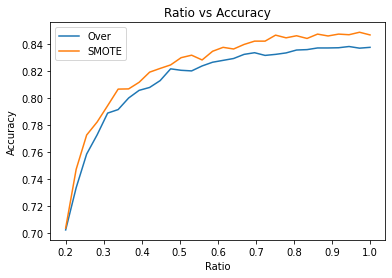

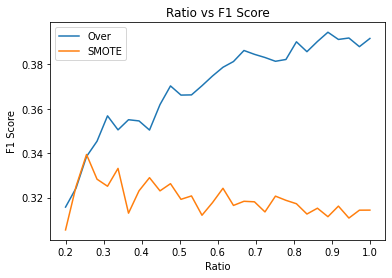

In [ ]:
#plot curves
plt.clf()
plt.plot(ratios,over_accuracies,label="Over")
plt.plot(ratios,smote_accuracies,label="SMOTE")
plt.xlabel("Ratio")
plt.ylabel("Accuracy")
plt.title("Ratio vs Accuracy")
plt.legend()
plt.show()

plt.clf()
plt.plot(ratios,over_f1s,label="Over")
plt.plot(ratios,smote_f1s,label="SMOTE")
plt.xlabel("Ratio")
plt.ylabel("F1 Score")
plt.title("Ratio vs F1 Score")
plt.legend()

In [ ]:
#Use ratio 0.88 with over sampling
resample_x, resample_y = over_sampling(train_x,train_y,0.88)
model = RandomForestClassifier(n_estimators=483,max_features="sqrt",max_depth=100,min_samples_leaf=5,bootstrap=False,random_state=0)
model.fit(resample_x, resample_y)
predict_y = model.predict(test_x)

accuracy: 0.8380119650253106
F1: 0.39588100686498856
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5703
           1       0.37      0.42      0.40       816

    accuracy                           0.84      6519
   macro avg       0.64      0.66      0.65      6519
weighted avg       0.85      0.84      0.84      6519

True Positive:346
True Negative:5117
False Positve:586
False Negative:470


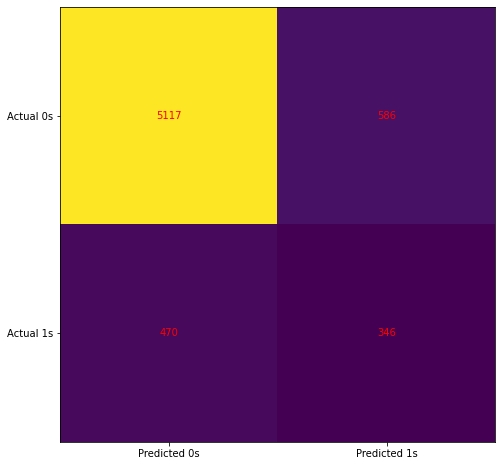

In [ ]:
#Result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

In [ ]:
#unhide it for generate validating set from training set
# train_x,validate_x,train_y,validate_y = train_test_split(train_x,train_y, test_size=0.2, random_state=0, stratify=train_y, shuffle=True)

# print(train_x.shape,train_y.shape)
# print(validate_x.shape,validate_y.shape)

In [ ]:
#Grid Search on best params for MLP
#hide it to prevent accidently run it

# hidden_layer_sizes = [(4,4,4),(8,8,8),(16,16,16),(32,32,32),(64,64,64),(24,12,6),(24,12),(12,6)]
# learning_rate_init = [0.005,0.001,0.01]
# max_iter = [500,1000,1500]
# early_stopping = [True]
# random_state = [0]
# grid = {'hidden_layer_sizes': hidden_layer_sizes,
#          'learning_rate_init': learning_rate_init,
#          'max_iter': max_iter,
#          'early_stopping': early_stopping,
#           'random_state': random_state}

# resample_x, resample_y = over_sampling(train_x,train_y,0.88)
# model = MLPClassifier()
# cv = KFold(3, shuffle=True, random_state=4211)
# rs = GridSearchCV(estimator=model,param_grid=grid,cv=cv,verbose=3,scoring="f1")
# rs.fit(resample_x,resample_y)
# rs.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END early_stopping=True, hidden_layer_sizes=(4, 4, 4), learning_rate_init=0.005, max_iter=500, random_state=0;, score=0.606 total time=   5.1s
[CV 2/3] END early_stopping=True, hidden_layer_sizes=(4, 4, 4), learning_rate_init=0.005, max_iter=500, random_state=0;, score=0.606 total time=   7.1s
[CV 3/3] END early_stopping=True, hidden_layer_sizes=(4, 4, 4), learning_rate_init=0.005, max_iter=500, random_state=0;, score=0.581 total time=   4.5s
[CV 1/3] END early_stopping=True, hidden_layer_sizes=(4, 4, 4), learning_rate_init=0.005, max_iter=1000, random_state=0;, score=0.606 total time=   4.8s
[CV 2/3] END early_stopping=True, hidden_layer_sizes=(4, 4, 4), learning_rate_init=0.005, max_iter=1000, random_state=0;, score=0.606 total time=   4.0s
[CV 3/3] END early_stopping=True, hidden_layer_sizes=(4, 4, 4), learning_rate_init=0.005, max_iter=1000, random_state=0;, score=0.581 total time=   6.4s
[CV 1/3] END early_stop

{'early_stopping': True,
 'hidden_layer_sizes': (64, 64, 64),
 'learning_rate_init': 0.005,
 'max_iter': 500,
 'random_state': 0}

Text(0.5, 1.0, 'H vs F1')

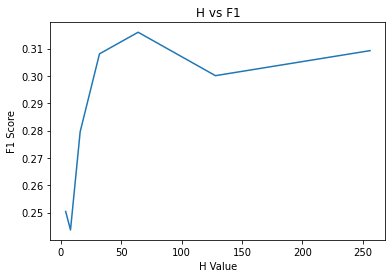

In [ ]:
#test whether larger number of hidden units in each layer will help
H = [4,8,16,32,64,128,256]
F1_scores = []

resample_x, resample_y = over_sampling(train_x,train_y,0.88)

for i in range(len(H)):
  model = MLPClassifier(early_stopping=True,hidden_layer_sizes=(H[i],H[i],H[i]),learning_rate_init=0.005,max_iter=500,random_state=0,verbose=0)
  model.fit(resample_x,resample_y)
  predict_y = model.predict(test_x)
  predict_y[predict_y >= 0.5] = 1
  predict_y[predict_y < 0.5] = 0
  F1_scores.append(f1_score(test_y, predict_y, average="binary"))

#plot the graph
plt.figure()
plt.plot(H, F1_scores)
plt.xlabel("H Value")
plt.ylabel("F1 Score")
plt.title("H vs F1")

In [ ]:
#Build the MLP model using the best params
resample_x, resample_y = over_sampling(train_x,train_y,0.88)

model = MLPClassifier(early_stopping=True,hidden_layer_sizes=(64,64,64),learning_rate_init=0.005,max_iter=500,random_state=0,verbose=0)
model.fit(resample_x,resample_y)
predict_y = model.predict(test_x)
predict_y[predict_y >= 0.5] = 1
predict_y[predict_y < 0.5] = 0


accuracy: 0.7741984967019482
F1: 0.3159851301115242
              precision    recall  f1-score   support

           0       0.91      0.83      0.86      5703
           1       0.25      0.42      0.32       816

    accuracy                           0.77      6519
   macro avg       0.58      0.62      0.59      6519
weighted avg       0.83      0.77      0.80      6519

True Positive:340
True Negative:4707
False Positve:996
False Negative:476


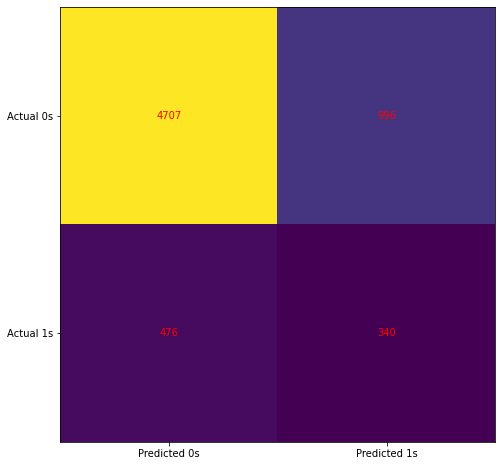

In [ ]:
#Result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

In [ ]:
#Grid Search on best params for SVM
#hide it to prevent accidently run it
# C = [0.1,1,10,100]
# kernel = ["rbf"] # non-linear kernel
# grid = {'C': C,
#     'kernel': kernel}

# resample_x, resample_y = over_sampling(train_x,train_y,0.88)
# model = SVC()
# cv = KFold(3, shuffle=True, random_state=4211)
# rs = GridSearchCV(estimator=model,param_grid=grid,cv=cv,verbose=3,scoring="f1")
# rs.fit(resample_x,resample_y)
# rs.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .................C=0.1, kernel=rbf;, score=0.610 total time= 1.9min
[CV 2/3] END .................C=0.1, kernel=rbf;, score=0.606 total time= 2.0min
[CV 3/3] END .................C=0.1, kernel=rbf;, score=0.607 total time= 2.4min
[CV 1/3] END ...................C=1, kernel=rbf;, score=0.683 total time= 1.8min
[CV 2/3] END ...................C=1, kernel=rbf;, score=0.677 total time= 1.5min
[CV 3/3] END ...................C=1, kernel=rbf;, score=0.678 total time= 1.5min
[CV 1/3] END ..................C=10, kernel=rbf;, score=0.761 total time= 2.3min
[CV 2/3] END ..................C=10, kernel=rbf;, score=0.764 total time= 2.2min
[CV 3/3] END ..................C=10, kernel=rbf;, score=0.762 total time= 2.6min
[CV 1/3] END .................C=100, kernel=rbf;, score=0.815 total time= 4.8min
[CV 2/3] END .................C=100, kernel=rbf;, score=0.815 total time= 4.5min
[CV 3/3] END .................C=100, kernel=rbf;,

{'C': 100, 'kernel': 'rbf'}

In [ ]:
#Build SVM model using best params
resample_x, resample_y = over_sampling(train_x,train_y,0.88)

model = SVC(kernel="rbf",C=100)
model.fit(resample_x,resample_y)
predict_y = model.predict(test_x) 

accuracy: 0.7283325663445314
F1: 0.3339601353892441
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      5703
           1       0.24      0.54      0.33       816

    accuracy                           0.73      6519
   macro avg       0.58      0.65      0.58      6519
weighted avg       0.84      0.73      0.77      6519

True Positive:444
True Negative:4304
False Positve:1399
False Negative:372


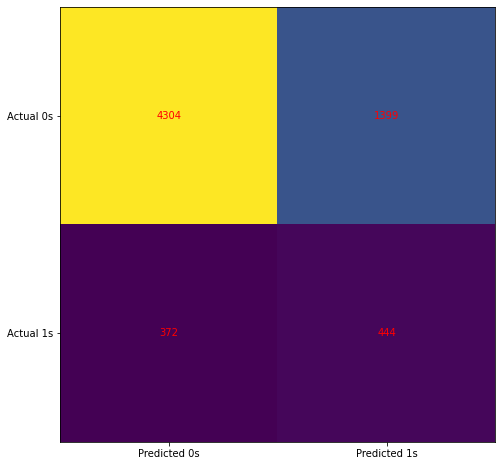

In [ ]:
#Result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

In [ ]:
#Anomaly dectection using OneClassSVM 
from sklearn.svm import OneClassSVM

percentage = train_y[train_y==1].shape[0]*1.0/train_y.shape[0] #percentage of high risk cases in training set
model = OneClassSVM(kernel="rbf", nu=percentage)

model.fit(train_x[train_y==0])
predict_y = model.predict(test_x)
predict_y[predict_y==1] = 0 # 1 = normal cases = majority class
predict_y[predict_y==-1] = 1 # -1 = anomaly cases = minority class

accuracy: 0.7812547936800123
F1: 0.15721040189125296
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      5703
           1       0.15      0.16      0.16       816

    accuracy                           0.78      6519
   macro avg       0.52      0.52      0.52      6519
weighted avg       0.79      0.78      0.78      6519

True Positive:133
True Negative:4960
False Positve:743
False Negative:683


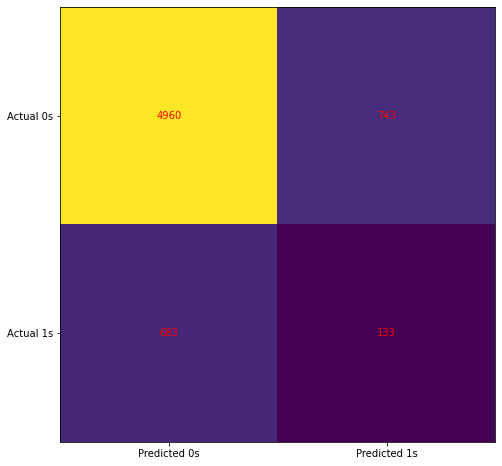

In [ ]:
#Result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

In [ ]:
#Grid Search on best params for LGBM 
#hide it to prevent accidently run it
# from lightgbm import LGBMClassifier

# n_estimators = [int(x) for x in np.linspace(start=200,stop=500,num=50)]
# max_depth = [int(x) for x in np.linspace(10,100,num=10)]
# min_samples_leaf = [int(x) for x in np.linspace(start=5,stop=25,num=5)]
# learning_rate = [0.5,0.1,0.05,0.01]
# min_child_weight = [int(x) for x in range(10)]
# subsample = [x for x in np.linspace(start=0.2,stop=1,num=5)]
# random_grid = {'n_estimators': n_estimators,
#          'max_depth': max_depth,
#          'min_samples_leaf': min_samples_leaf,
#         'learning_rate': learning_rate,
#         'min_child_weight': min_child_weight,
#         'subsample': subsample}

# resample_x, resample_y = over_sampling(train_x,train_y,0.88)
# model = LGBMClassifier(random_state=0,objective="binary")
# cv = KFold(3, shuffle=True, random_state=4211)
# rs = RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=100,cv=cv,verbose=3,scoring="f1",random_state=0)
# rs.fit(resample_x,resample_y)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END learning_rate=0.01, max_depth=70, min_child_weight=9, min_samples_leaf=5, n_estimators=481, subsample=1.0;, score=0.718 total time=   6.3s
[CV 2/3] END learning_rate=0.01, max_depth=70, min_child_weight=9, min_samples_leaf=5, n_estimators=481, subsample=1.0;, score=0.716 total time=   4.1s
[CV 3/3] END learning_rate=0.01, max_depth=70, min_child_weight=9, min_samples_leaf=5, n_estimators=481, subsample=1.0;, score=0.718 total time=   4.1s
[CV 1/3] END learning_rate=0.05, max_depth=50, min_child_weight=4, min_samples_leaf=15, n_estimators=457, subsample=0.4;, score=0.817 total time=   3.3s
[CV 2/3] END learning_rate=0.05, max_depth=50, min_child_weight=4, min_samples_leaf=15, n_estimators=457, subsample=0.4;, score=0.824 total time=   3.3s
[CV 3/3] END learning_rate=0.05, max_depth=50, min_child_weight=4, min_samples_leaf=15, n_estimators=457, subsample=0.4;, score=0.820 total time=   3.2s
[CV 1/3] END learning_

{'subsample': 0.8,
 'n_estimators': 420,
 'min_samples_leaf': 15,
 'min_child_weight': 0,
 'max_depth': 100,
 'learning_rate': 0.5}

In [ ]:
from lightgbm import LGBMClassifier
resample_x, resample_y = over_sampling(train_x,train_y,0.88)
model = LGBMClassifier(n_estimators=200,max_depth=420,min_samples_leaf=100,learning_rate=0.5,subsample=0.8,min_child_weight=0)
model.fit(resample_x,resample_y)
predict_y = model.predict(test_x)

accuracy: 0.7988955361251726
F1: 0.3402113739305486
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      5703
           1       0.29      0.41      0.34       816

    accuracy                           0.80      6519
   macro avg       0.60      0.63      0.61      6519
weighted avg       0.83      0.80      0.81      6519

True Positive:338
True Negative:4870
False Positve:833
False Negative:478


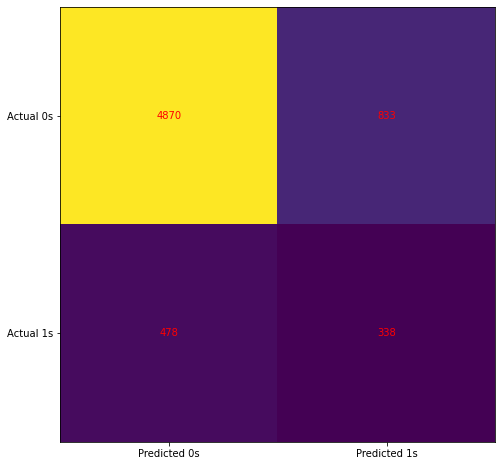

In [ ]:
#Result
prediction_analyze(test_y,predict_y)
cm = confusion_matrix(test_y,predict_y)
draw_confusion_matrix(cm)

Text(0.5, 1.0, 'K vs SSE')

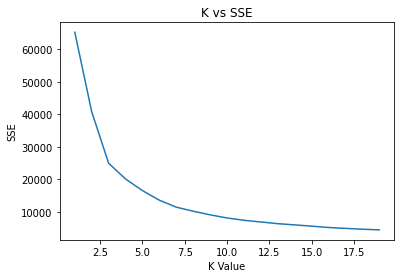

In [ ]:
#Clustering on columns {Age, Total_income, Years_employed}
#Elbow Methods

SSE = []
Ks = [x for x in range(1,20)]
data= dataset[["Age","Total_income"]].to_numpy()
data_scale = StandardScaler().fit_transform(data)

for k in Ks:
  model = KMeans(n_clusters=k)
  model.fit(data_scale)

  SSE.append(model.inertia_)

#plot the SSE curve
plt.figure()
plt.plot(Ks, SSE)
plt.xlabel("K Value")
plt.ylabel("SSE")
plt.title("K vs SSE")

[[-0.7917972  -0.24169707]
 [ 1.01680406 -0.37798192]
 [-0.03932569  1.78891388]]
24958.156263853518


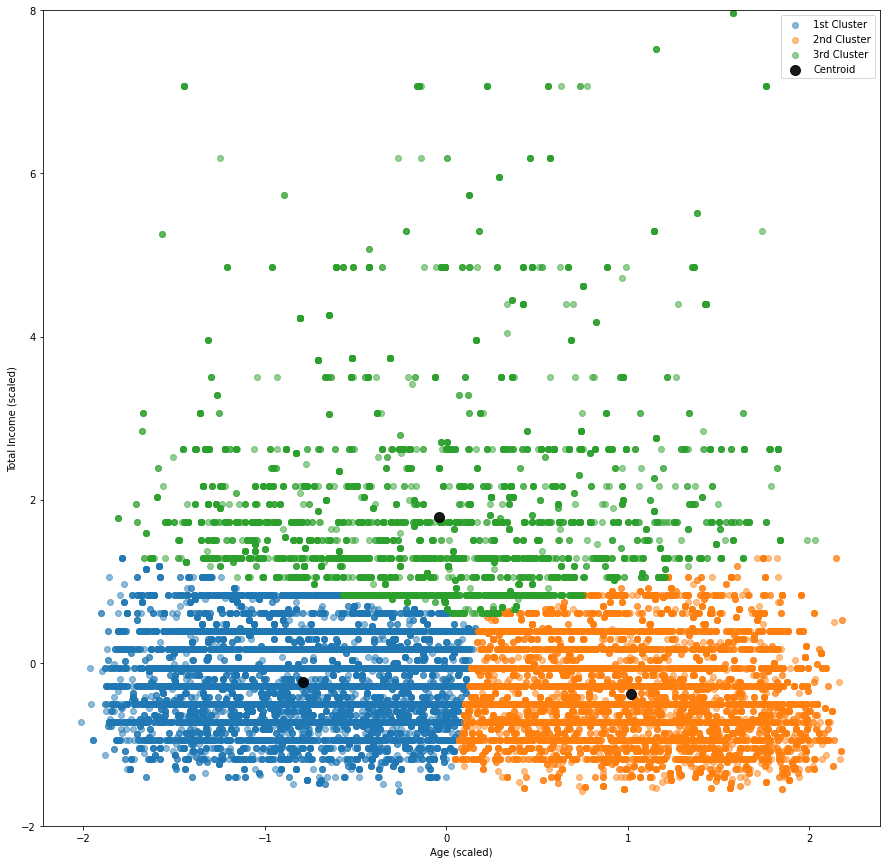

In [ ]:
#Clustering using best k
data= dataset[["Age","Total_income"]].to_numpy()
data_scale = StandardScaler().fit_transform(data)
model = KMeans(n_clusters=3)
model.fit(data_scale)

prediction = model.predict(data_scale)
centroids = model.cluster_centers_
print(centroids)
print(model.inertia_)
fig = plt.figure()
plt.scatter(data_scale[prediction==0,0],data_scale[prediction==0,1],label="1st Cluster",alpha=0.5)
plt.scatter(data_scale[prediction==1,0],data_scale[prediction==1,1],label="2nd Cluster",alpha=0.5)
plt.scatter(data_scale[prediction==2,0],data_scale[prediction==2,1],label="3rd Cluster",alpha=0.5)
# plt.scatter(data_scale[prediction==3,0],data_scale[prediction==3,1],label="4th Cluster",alpha=0.5)
plt.scatter(centroids[:,0],centroids[:,1],c="black",s=100,label="Centroid",alpha=0.9)
plt.legend()
plt.xlabel("Age (scaled)")
plt.ylabel("Total Income (scaled)")
plt.ylim(-2, 8)
fig.set_size_inches(15, 15)